<a href="https://colab.research.google.com/github/monouns/Portfolio-Allocation-tutorial/blob/master/FinRL_StockTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-gedozhmc
  Running command git clone -q https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-gedozhmc
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-5d5t49w8/pyfolio_3e1971c353ff4f1d92f222a7c7967650
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-5d5t49w8/pyfolio_3e1971c353ff4f1d92f222a7c7967650
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-5d5t49w8/elegantrl_dbf3942a78f14f0db5d450e4fefc00f2
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-5d5t49w8/elegantrl_dbf3942a78f14f0db5d450e4fefc00f2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [3]:
from finrl import config
from finrl import config_tickers
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

<a id='1.3'></a>
## 2.2. Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).


## 3.1 YahooDownloader

-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
# from config.py TRAIN_START_DATE is a string
config.TRAIN_START_DATE

'2014-01-01'

In [7]:
# from config.py TRAIN_END_DATE is a string
config.TRAIN_END_DATE

'2020-07-31'

In [73]:
df = YahooDownloader(start_date = '2021-01-01',
                     end_date = '2021-10-31',
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [74]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [75]:
df.shape

(6270, 8)

In [76]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2021-01-04,133.520004,133.610001,126.760002,128.264984,143301900,AAPL,0
1,2021-01-04,231.250000,231.250000,223.669998,216.251816,3088200,AMGN,0
2,2021-01-04,121.300003,121.800003,116.849998,116.058228,3472100,AXP,0
3,2021-01-04,210.000000,210.199997,202.490005,202.720001,21225600,BA,0
4,2021-01-04,183.000000,185.979996,180.250000,176.713654,4078300,CAT,0


In [77]:
df.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
tic        object
day         int64
dtype: object

## 3.2 FinanceDataReader

In [5]:
!pip install finance-datareader --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import FinanceDataReader as fdr
fdr.__version__

'0.9.33'

In [7]:
import pandas as pd
from tqdm.notebook import tqdm

In [8]:
#You must have stock_list.csv file before running the code!
stock_list = pd.read_csv('./stock_list.csv')
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x : str(x).zfill(6))
stock_list.set_index('종목코드', inplace=True)
stock_list

,종목명,상장시장
종목코드,,
005930,삼성전자,KOSPI
000660,SK하이닉스,KOSPI
035420,NAVER,KOSPI
035720,카카오,KOSPI
207940,삼성바이오로직스,KOSPI
...,...,...
220630,맘스터치,KOSDAQ
064260,다날,KOSDAQ
287410,제이시스메디칼,KOSDAQ


In [9]:
ticker=  stock_list.index
datetime = ['2021-01-01', '2022-05-26']
data = pd.DataFrame()
#data = pd.read_csv('./data.csv') 
for code in tqdm(list(ticker)):
    df = pd.DataFrame()
    stock = fdr.DataReader(code, start = datetime[0], end = datetime[1])
    if not stock.empty:
      df = stock.copy().iloc[:, :5]
      df['tic'] = code
      df['day'] = stock.reset_index().iloc[:,0].dt.day.values

      df.reset_index(inplace=True)

      data = pd.concat([data, df], axis=0)

data.rename(columns={"Date":"date", "Open": "open", "High": "high", "Close":"close", "Volume": "volume"}, inplace=True)
data

  0%|          | 0/370 [00:00<?, ?it/s]

,date,open,high,Low,close,volume,tic,day
0,2021-01-04,81000,84400,80200,83000,38655276,005930,4
1,2021-01-05,81600,83900,81600,83900,35335669,005930,5
2,2021-01-06,83300,84500,82100,82200,42089013,005930,6
3,2021-01-07,82800,84200,82700,82900,32644642,005930,7
4,2021-01-08,83300,90000,83000,88800,59013307,005930,8
...,...,...,...,...,...,...,...,...
341,2022-05-20,47650,47850,47100,47650,64982,099320,20
342,2022-05-23,48000,49900,47950,48450,139226,099320,23
343,2022-05-24,48550,48700,47350,47350,52369,099320,24
344,2022-05-25,47900,49100,47500,48800,74095,099320,25


In [10]:
df = data.copy()
df = df.sort_values(['date','tic'],ignore_index=True)
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df = df.astype({'date': 'object'})
df

,date,open,high,Low,close,volume,tic,day
0,2021-01-04,14650,14650,14000,14250,876899,000060,4
1,2021-01-04,31950,32000,31500,32000,462233,000080,4
2,2021-01-04,72447,76275,72256,75797,1086898,000100,4
3,2021-01-04,167500,169000,163500,168500,118757,000120,4
4,2021-01-04,52500,52700,51000,52000,126798,000150,4
...,...,...,...,...,...,...,...,...
127783,2022-05-26,67000,68300,66200,66300,31842,348210,26
127784,2022-05-26,220000,221500,213500,214500,133881,352820,26
127785,2022-05-26,266700,276800,266500,270900,70362,357780,26
127786,2022-05-26,24550,24700,24350,24600,23107,363280,26


In [11]:
df.dtypes

date      object
open       int64
high       int64
Low        int64
close      int64
volume     int64
tic       object
day        int64
dtype: object

In [13]:
df.to_csv('./data2.csv', index=0)

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [5]:
df = pd.read_csv('./data2.csv')

In [6]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = config.INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (352, 8)
Successfully added vix
Successfully added turbulence index


In [7]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [8]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,Low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2021-01-04,60,14650.0,14650.0,14000.0,14250.0,876899.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,14250.0,14250.0,26.969999,0.0
1,2021-01-04,80,31950.0,32000.0,31500.0,32000.0,462233.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,32000.0,32000.0,26.969999,0.0
2,2021-01-04,100,72447.0,76275.0,72256.0,75797.0,1086898.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,75797.0,75797.0,26.969999,0.0
3,2021-01-04,120,167500.0,169000.0,163500.0,168500.0,118757.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,168500.0,168500.0,26.969999,0.0
4,2021-01-04,150,52500.0,52700.0,51000.0,52000.0,126798.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,52000.0,52000.0,26.969999,0.0
5,2021-01-04,240,14300.0,14450.0,14150.0,14400.0,271945.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,14400.0,14400.0,26.969999,0.0
6,2021-01-04,250,83200.0,83200.0,79800.0,81800.0,883070.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,81800.0,81800.0,26.969999,0.0
7,2021-01-04,270,62400.0,64800.0,61700.0,64000.0,5602314.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,64000.0,64000.0,26.969999,0.0
8,2021-01-04,660,124500.0,128000.0,120500.0,126000.0,7995016.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,126000.0,126000.0,26.969999,0.0
9,2021-01-04,670,532000.0,540000.0,516000.0,540000.0,2547.0,4.0,0.0,14432.842712,13867.157288,0.0,-66.666667,100.0,540000.0,540000.0,26.969999,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data split: 2021-01-01 to 2021-04-31
## Trade data split: 2022-05-01 to 2022-05-26

In [9]:
train = data_split(processed_full, '2021-01-01','2022-04-31')
trade = data_split(processed_full, '2022-05-01','2022-05-26')
print(len(train))
print(len(trade))

116656
6256


In [10]:
tmp_train = pd.DataFrame()
tmp_trade = pd.DataFrame()

tmp_train['date'] = train['date']
tmp_train['tic'] = train['tic']
tmp_train['day'] = train['day']
tmp_train['index'] = train.index

tmp_trade['date'] = trade['date']
tmp_trade['tic'] = trade['tic']
tmp_trade['day'] = trade['day']
tmp_trade['index'] = trade.index

train.drop(columns = ['date', 'tic', 'day'], inplace=True)
trade.drop(columns = ['date', 'tic', 'day'], inplace=True)

In [11]:
X_traintrain = train.values.astype(np.float)
print(np.where(np.isin(X_traintrain, [np.nan, np.inf, -np.inf]).any(1)==True))

(array([ 98781, 100621, 101725, 102829, 103933, 105037, 106141, 109085,
       110189, 111293, 112397, 113133, 114237, 115341]),)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [12]:
X_tradetrade = trade.values.astype(np.float)
print(np.where(np.isin(X_tradetrade, [np.nan, np.inf, -np.inf]).any(1)==True))

(array([3617, 4721]),)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [13]:
train_index=np.where(np.isin(X_traintrain, [np.nan, np.inf, -np.inf]).any(1)==True)
trade_index =np.where(np.isin(X_tradetrade, [np.nan, np.inf, -np.inf]).any(1)==True)

X_traintrain[train_index] = np.nan
X_tradetrade[trade_index]=np.nan

print(np.isnan(X_traintrain).sum(), np.isnan(X_tradetrade).sum())

210 30


In [27]:
X_train = pd.DataFrame(X_traintrain, columns = train.columns).interpolate(direction='both', method='linear')
X_trade = pd.DataFrame(X_tradetrade, columns = trade.columns).interpolate(direction='both', method='linear')

print(X_train.isna().sum(). sum(), X_trade.isna().sum(). sum())

0 0


In [28]:
X_train.insert(0, 'date', tmp_train['date'].values)
X_trade.insert(0, 'date', tmp_trade['date'].values)

X_train.insert(1, 'tic', tmp_train['tic'].values)
X_trade.insert(1, 'tic', tmp_trade['tic'].values)

X_train.insert(7, 'day', tmp_train['day'].values)
X_trade.insert(7, 'day', tmp_trade['day'].values)

X_train.insert(0, 'index_', tmp_train['index'].values)
X_trade.insert(0, 'index_', tmp_trade['index'].values)

X_train.set_index('index_', inplace=True)
X_trade.set_index('index_', inplace=True)

In [29]:
config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [30]:
traintrain = X_train.copy()
tradetrade = X_trade.copy()

In [32]:
stock_dimension = len(traintrain.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 368, State Space: 3681


In [33]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 2000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = traintrain, **env_kwargs)

## Environment for Training



In [35]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [36]:
agent = DRLAgent(env = env_train)

### Model: DDPG

In [37]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [38]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=30000)

-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 71         |
|    time_elapsed    | 17         |
|    total_timesteps | 1268       |
| train/             |            |
|    actor_loss      | 9.5e+03    |
|    critic_loss     | 1.78e+05   |
|    learning_rate   | 0.001      |
|    n_updates       | 951        |
|    reward          | -6.8600926 |
-----------------------------------
day: 316, episode: 10
begin_total_asset: 2000000.00
end_total_asset: 1998002.00
total_reward: -1998.00
total_cost: 1998.00
total_trades: 61620
Sharpe: 0.226
-----------------------------------
| time/              |            |
|    episodes        | 8          |
|    fps             | 64         |
|    time_elapsed    | 39         |
|    total_timesteps | 2536       |
| train/             |            |
|    actor_loss      | 8.95e+03   |
|    critic_loss     | 1.15e+06   |
|    learning_rate   | 0.001      |
|    n_updates 

## Trading
Assume that we have 2,000,000 initial capital at 2021-01-01. We use the DDPG model to trade KOSPI& KOSDAQ about 300 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [39]:
data_risk_indicator = processed_full[(processed_full.date<'2022-04-31') & (processed_full.date>='2021-01-01')]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [40]:
insample_risk_indicator.vix.describe()

count    317.000000
mean      20.902871
std        4.611751
min       15.010000
25%       17.330000
50%       19.610001
75%       22.959999
max       37.209999
Name: vix, dtype: float64

In [41]:
insample_risk_indicator.vix.quantile(0.996)

36.101520843505845

In [42]:
insample_risk_indicator.turbulence.describe()

count     317.000000
mean      134.011035
std       281.371324
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1290.523714
Name: turbulence, dtype: float64

In [43]:
insample_risk_indicator.turbulence.quantile(0.996)

1152.1188077537558

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [44]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = tradetrade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [45]:
tradetrade.head()

,date,tic,open,high,Low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
index_,,,,,,,,,,,,,,,,,,
0,2022-05-02,60,43400.0,44600.0,43400.0,44350.0,159151.0,2.0,-6.014343,49341.647379,43393.352621,51.136884,-85.394008,11.517014,45973.333333,43825.833333,32.34,487.29417
0,2022-05-02,80,37250.0,37600.0,36800.0,37450.0,214519.0,2.0,198.675445,37992.079503,35942.920497,56.057365,48.313986,5.961296,37060.000000,36353.333333,32.34,487.29417
0,2022-05-02,100,60700.0,60900.0,60400.0,60900.0,125568.0,2.0,519.112046,61544.459848,57815.540152,55.069176,155.580468,24.329167,59406.666667,58536.666667,32.34,487.29417
0,2022-05-02,120,122500.0,123500.0,121000.0,122500.0,18957.0,2.0,-1734.236119,132467.649757,118082.350243,45.386021,-94.928479,23.624334,126800.000000,127100.000000,32.34,487.29417
0,2022-05-02,150,88300.0,89300.0,86400.0,87700.0,73959.0,2.0,-4624.604568,104286.116440,86053.883560,39.651563,-132.992967,36.074442,99413.333333,102603.333333,32.34,487.29417


In [46]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [47]:
df_account_value.shape

(17, 2)

In [48]:
df_account_value.tail()

,date,account_value
12,2022-05-19,1.740749e+06
13,2022-05-20,1.792199e+06
14,2022-05-23,1.800774e+06
15,2022-05-24,1.757899e+06
16,2022-05-25,1.757899e+06


In [49]:
df_actions.tail()

,60,80,100,120,150,240,250,270,660,670,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
date,,,,,,,,,,,,,,,,,,,,,
2022-05-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-05-19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-05-20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-05-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2022-05-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
np.unique(df_actions.values)

array([ 0, 17])

In [58]:
np.where(df_actions.values > 0)

(array([0]), array([183]))

In [69]:
df_actions.iloc[0, [183]]

66570    17
Name: 2022-05-02, dtype: int64

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [51]:
import datetime
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return         -0.852312
Cumulative returns    -0.121051
Annual volatility      0.295178
Sharpe ratio          -6.716849
Calmar ratio          -6.575172
Stability              0.876530
Max drawdown          -0.129626
Omega ratio            0.278091
Sortino ratio         -7.009352
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.537502
Daily value at risk   -0.045057
dtype: float64


In [52]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (17, 8)
Annual return         -0.403602
Cumulative returns    -0.034266
Annual volatility      0.270201
Sharpe ratio          -1.902766
Calmar ratio          -4.895825
Stability              0.579712
Max drawdown          -0.082438
Omega ratio            0.711903
Sortino ratio         -2.436539
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.676580
Daily value at risk   -0.036082
dtype: float64


In [53]:
df_account_value.loc[0,'date']

'2022-05-02'

In [54]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-05-25'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (17, 8)


Start date,2022-05-02
End date,2022-05-25
Total months,0
,Backtest
Annual return,-85.231%
Cumulative returns,-12.105%
Annual volatility,29.518%
Sharpe ratio,-6.72
Calmar ratio,-6.58
Stability,0.88
Max drawdown,-12.963%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.96,2022-05-02,2022-05-19,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,-0.79%,-5.14%,2.96%


/usr/local/lib/python3.7/dist-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


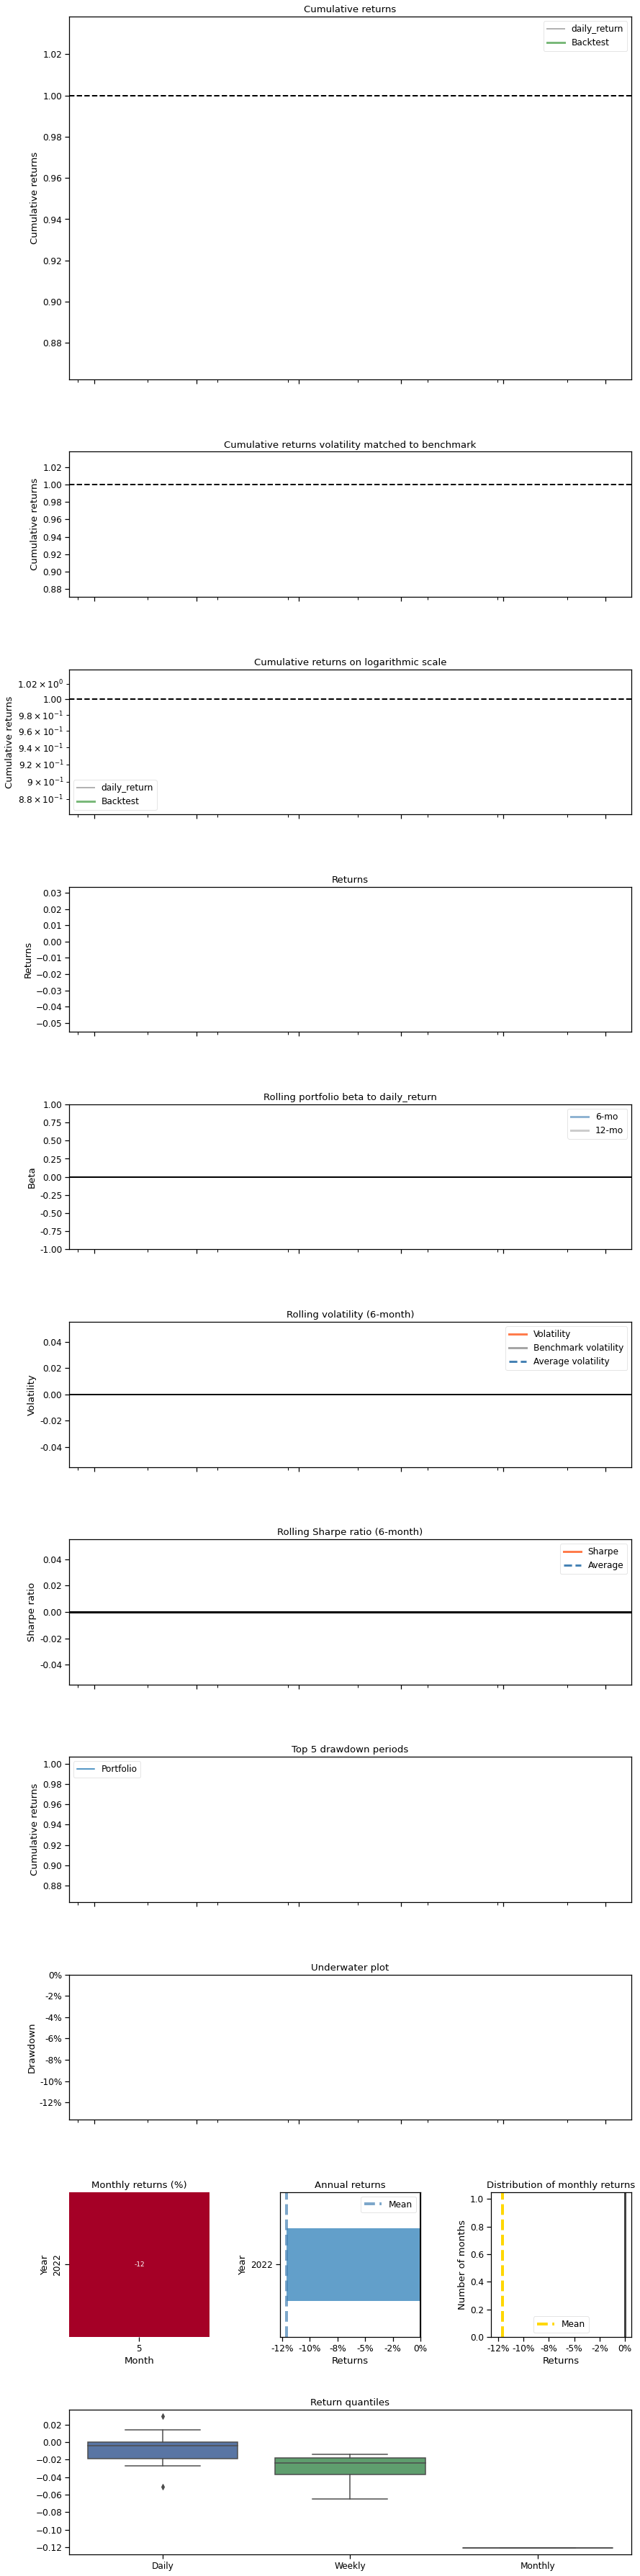

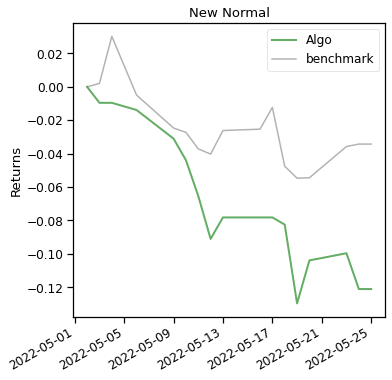

In [55]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])